In [1]:
import argparse
import os
import random
import json
import shutil
import time
import warnings
import torch.cuda as cuda
import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
from logger import Logger
import os
from torch.nn.modules.loss import _Loss
import VGG_ImageNet as models
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import PIL.Image as Image
from convOut_loader import convOut_Dataset

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [138]:
device_ids=[0,1]
arch='vgg16_bn_ft'
seed=0
batch_size=64
resume='model_checkpoints/checkpoint_CUB200_vgg16_bn_ft_full_B.pth.tar'
# resume2='model_best_CUB200__vgg16_bn_sd_10_ep300.pth.tar'
dataset='CUB200'
conv_layer=40
topk=[1,3]

In [3]:
def load_checkpoint(resume, model):
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume, map_location=torch.device("cuda:{}".format(device_ids[0])))
        state_dict = checkpoint['state_dict']
        keys = list(state_dict.keys())
        for key in keys:
            if key.find('module'):
                state_dict[key.replace('module.','')] = state_dict.pop(key)

        model.load_state_dict(state_dict)
        print("=> loaded checkpoint '{}' (epoch {} acc1 {})"
              .format(resume, checkpoint['epoch'], checkpoint['best_acc1']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))
    del checkpoint, state_dict

In [139]:
cudnn.benchmark = True
if dataset == 'CUB200':
    net = models.__dict__[arch](num_classes=200).cuda(device_ids[0])

load_checkpoint(resume, net)

net.eval()

=> loading checkpoint 'model_checkpoints/checkpoint_CUB200_vgg16_bn_ft_full_B.pth.tar'
=> loaded checkpoint 'model_checkpoints/checkpoint_CUB200_vgg16_bn_ft_full_B.pth.tar' (epoch 240 acc1 69.5547103881836)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [5]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

if dataset == 'ilsvrc':
    valdir = '../ILSVRC2012_img_val'
    val_dataset = datasets.ImageFolder(
        valdir, T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            normalize,
        ]))
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True)

    criterion = nn.CrossEntropyLoss()  # .cuda(gpu_id)

    optimizer = torch.optim.SGD(net.parameters(), lr,
                                momentum=momentum,
                                weight_decay=weight_decay)
elif dataset == 'cifar10':
    transform_test = T.Compose([
        T.ToTensor(),  # [0, 256] -> [0, 1]
        T.Normalize(mean=[0.4914, 0.4822, 0.4465],  # mean
                    std=[0.2470, 0.2435, 0.2616]),  # std
    ])

    val_dataset = datasets.CIFAR10(root='../data/CIFAR10', train=True,
                                   download=True, transform=transform_test)

elif dataset == 'CUB':
    valdir = '../../CUB_bird_binary/val/'

    normalize = T.Normalize(mean=[0.4795, 0.4822, 0.4218],
                            std=[0.2507, 0.2469, 0.2760])

    val_dataset = datasets.ImageFolder(valdir, T.Compose([
        T.Resize(224),
        T.ToTensor(),
        normalize,
    ]))

elif dataset == 'CUB200':
    valdir = '../../CUB_200_2011/crop/test'
    val_dataset = datasets.ImageFolder(
        valdir, T.Compose([
#                 T.RandomResizedCrop(224),
#                 T.RandomHorizontalFlip(),
            T.Resize((224,224)),
#             T.CenterCrop(224),
            T.ToTensor(),
            normalize,
        ]))
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=6, pin_memory=True)
    # class_map = [[] for i in range(200)]
    # for i in range(len(val_dataset)):
    #     class_map[val_dataset[i][1]].append(i)

In [6]:
denormalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                        std=[1/0.229, 1/0.224, 1/0.225])
toPIL = T.Compose([denormalize, T.ToPILImage()])

(224, 224)


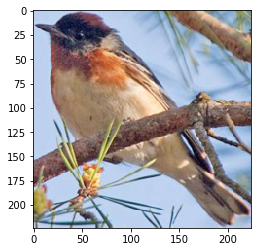

In [7]:
a = toPIL(val_dataset[4546][0])
print(a.size)
plt.imshow(a)

In [153]:
model = 'new'
convOut_path = './ConvOut/convOut_CUB200_vgg16_bn_ft_L40_v3.pkl'
resume_M = './checkpoint_CUB200_V0_alpha0.01.pth.tar'
gpu = 0

In [9]:
if model == 'residual':
    from linearTest_v2 import LinearTester
elif model == 'new':
    from linearTest import LinearTester
elif model == 'bug':
    from linearTest_bn_problem import LinearTester
else:
    from linearTest_v0 import LinearTester

In [116]:
from torch.utils.data.sampler import SubsetRandomSampler
sub_idx = np.load('sub_sampler_CUB200_V.npy').tolist()

In [135]:
train_dataset = convOut_Dataset(convOut_path)
input_size = train_dataset.convOut1.shape[1:4]
output_size = train_dataset.convOut2.shape[1:4]

In [151]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True, sampler=SubsetRandomSampler(sub_idx))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [155]:
model = LinearTester(input_size,output_size, gpu_id= gpu).cuda(gpu)
checkpoint = torch.load(resume_M, map_location=torch.device("cuda:{}".format(gpu)))
model.load_state_dict(checkpoint['state_dict'])
del checkpoint

In [125]:
net.features[41:]

Sequential(
  (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (42): ReLU(inplace)
  (43): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [15]:
class TransClassifier(nn.Module):
    def __init__(self, ori_net, layer):
        super(TransClassifier, self).__init__()
        self.features = ori_net.features[layer:]
        self.classifier = ori_net.classifier

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


In [16]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [17]:
criterion = nn.CrossEntropyLoss().cuda(gpu)

In [140]:
Classifier = TransClassifier(net, 41)

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [156]:
Classifier.eval()
model.eval()
losses_TP = AverageMeter()
top1_TP = AverageMeter()
top5_TP = AverageMeter()
losses_GT = AverageMeter()
top1_GT = AverageMeter()
top5_GT = AverageMeter()
with torch.no_grad():
    for i, batch in enumerate(train_loader):
        print(i,end=' ')
        input = batch['convOut1'].cuda(gpu, non_blocking=True)
        gtfeature = batch['convOut2'].cuda(gpu, non_blocking=True)
        target = batch['target'].type(torch.long).cuda(gpu, non_blocking=True)
        outfeature = model(input)
        output_TP = Classifier(outfeature)
        output_GT = Classifier(gtfeature)

        loss_TP = criterion(output_TP, target)
        loss_GT = criterion(output_GT, target)
        acc1_TP, acc5_TP = accuracy(output_TP, target, topk=(1,5))
        acc1_GT, acc5_GT = accuracy(output_GT, target, topk=(1,5))
        losses_TP.update(loss_TP.item(), input.size(0))
        top1_TP.update(acc1_TP[0], input.size(0))
        top5_TP.update(acc5_TP[0], input.size(0))
        losses_GT.update(loss_GT.item(), input.size(0))
        top1_GT.update(acc1_GT[0], input.size(0))
        top5_GT.update(acc5_GT[0], input.size(0))
    
    
print()
print(top1_GT.avg, top1_TP.avg)
print(top5_GT.avg, top5_TP.avg)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 
tensor(67.8806, device='cuda:0') tensor(68.3120, device='cuda:0')
tensor(90.6110, device='cuda:0') tensor(90.7145, device='cuda:0')


In [31]:
sub_M = np.load('sub_sampler_CUB200_M.npy').tolist()

In [32]:
sub_M[:30]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37]

In [158]:
nn.Sigmoid()(torch.Tensor([0.]))

tensor([0.5000])

In [159]:
0.0 == 0

True